# _1_. 동의어에 대해 Embedding Vector 수치 확인

> 유의어, 동의어 구별이 안 된다. 당연히 똑같다.

* 동의어 있는 문장 확인
    - vocab_dict 생성
    - decode 이용해서 동의어 있나 확인
    - 동의어 있는 문장 인덱스 저장

* Functional API로 임베딩 레이어 구성

* Embedding latent feature 추출하여 임베딩된 수치 확인 

In [4]:
# 모듈 불러오기

import random

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# IMDB 데이터셋 문장 decode
def decode_sent(sentences):
    '''
    - 0: padding, 1: start, 2: OOV
    - 실제 word index에서 3을 빼고, 없으면 '*'로 채운다.
    '''
    temp_sent = []
    for sent in sentences:
        temp = imdb_vocab_dict.get(sent-3, '*')
        temp_sent.append(temp)
    
    comb_sent = " ".join(temp_sent)

    return comb_sent

In [6]:
# 아무 단어나 문단에서 찾아오는 함수
def check_syn(sentences, dictionary, threshold, k=10):

    syn_idx = random.randint(3, max_features) # 숫자: 찾을 동의어 인덱스.
    synonym = dictionary[syn_idx]
    print(f"찾을 단어 인덱스: {syn_idx}, 찾을 단어: {synonym}") # 확인용

    common_sentences = []

    cnt = 0
    for i in range(len(sentences)):
        if cnt == k:
            break
        sent = sentences[i]
        decoded_sent = decode_sent(sent)        
        if synonym in decoded_sent:
            print(f"{i}번째 문장:\n    {decoded_sent}") # 확인용
            cnt += 1
            common_sentences.append(i)

    return common_sentences

In [7]:
# 문장 길이 체크
def check_len(m, sentences):
    cnt = 0
    for sent in sentences:
        if len(sent) <= m:
            cnt += 1
    
    return f'전체 문장 중 길이가 {m} 이하인 샘플의 비율: {(cnt/len(sentences))*100}'

In [8]:
# 데이터 로드
max_features = int(input('최대 단어 빈도 설정: '))
(X_train_raw, y_train), (X_test_raw, y_test) = imdb.load_data(num_words=max_features)

# 원본 데이터 보존 및 데이터 준비
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()
print(f"훈련 데이터: {X_train.shape}, 훈련 라벨: {y_train.shape}")
print(f"테스트 데이터: {y_train.shape}, 테스트 라벨: {y_test.shape}")
print()

# 어휘 사전
vocabulary = imdb.get_word_index()
imdb_vocab_dict = dict((v, k) for k, v in vocabulary.items())

# 문장 패딩 길이 설정
for length in range(100, 1000, 50):
    print(check_len(length, X_train))
print()
max_length = int(input('문장 패딩 길이 설정: '))

# 패딩
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# 모델 파라미터 설정
BATCH = int(input('배치 사이즈 설정: '))
EMBED_DIM = int(input('임베딩 차원 설정: '))
n_hidden = int(input('은닉 노드 수 설정: '))
EPOCHS = int(input('학습 횟수 설정: '))

# 모델 레이어 설정 및 구성
X_input = Input(batch_shape=(None, max_length)) # 시퀀스 길이만큼 들어간다
X_embed = Embedding(input_dim=max_features, output_dim=EMBED_DIM, input_length=max_length)(X_input)
X_lstm = Bidirectional(LSTM(n_hidden))(X_embed) # many to one이므로 return sequences 없음
y_output = Dense(1, activation='sigmoid')(X_lstm)

# 모델 구성
model = Model(X_input, y_output)
embed_model = Model(X_input, X_embed) ### 이

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002))
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
print()

# 임베딩 모델 확인
print("========== 임베딩 모델 구조 확인 ==========")
print(embed_model.summary())
print()

# 모델 훈련
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
hist = model.fit(X_train, y_train,
                 batch_size=BATCH,
                 epochs=EPOCHS,
                 validation_data=(X_test, y_test),
                 callbacks=[es])

# 임베딩 latent feature 확인
embedded_sentences = embed_model.predict(X_train)
print(f"임베딩된 문장: {embedded_sentences.shape}")
print()

# 동의어 찾기
synonyms = check_syn(X_train, imdb_vocab_dict, max_features)
print()

# 동음이의어 있는 문장 확인: '*'이 많아서 문장으로만 보면 다 이렇게 보인다.
for idx in synonyms:
    print(decode_sent(X_train_raw[idx]))
    print(embedded_sentences[idx, :, :])
    print()

최대 단어 빈도 설정: 6000
17465344/17464789 [==============================] - 0s 0us/step
훈련 데이터: (25000,), 훈련 라벨: (25000,)
테스트 데이터: (25000,), 테스트 라벨: (25000,)
1646592/1641221 [==============================] - 0s 0us/step
전체 문장 중 길이가 100 이하인 샘플의 비율: 11.288
전체 문장 중 길이가 150 이하인 샘플의 비율: 37.732
전체 문장 중 길이가 200 이하인 샘플의 비율: 57.292
전체 문장 중 길이가 250 이하인 샘플의 비율: 68.688
전체 문장 중 길이가 300 이하인 샘플의 비율: 76.36800000000001
전체 문장 중 길이가 350 이하인 샘플의 비율: 81.93599999999999
전체 문장 중 길이가 400 이하인 샘플의 비율: 86.064
전체 문장 중 길이가 450 이하인 샘플의 비율: 89.184
전체 문장 중 길이가 500 이하인 샘플의 비율: 91.56800000000001
전체 문장 중 길이가 550 이하인 샘플의 비율: 93.308
전체 문장 중 길이가 600 이하인 샘플의 비율: 94.812
전체 문장 중 길이가 650 이하인 샘플의 비율: 95.92399999999999
전체 문장 중 길이가 700 이하인 샘플의 비율: 96.72800000000001
전체 문장 중 길이가 750 이하인 샘플의 비율: 97.432
전체 문장 중 길이가 800 이하인 샘플의 비율: 98.012
전체 문장 중 길이가 850 이하인 샘플의 비율: 98.5
전체 문장 중 길이가 900 이하인 샘플의 비율: 98.832
전체 문장 중 길이가 950 이하인 샘플의 비율: 99.136

문장 패딩 길이 설정: 700
배치 사이즈 설정: 32
임베딩 차원 설정: 60
은닉 노드 수 설정: 128
학습 횟수 설정: 1000
========== 모델 전체 구조 확인 =

In [ ]:
# 가중치 행렬을 찍고, 원핫 순서니까 father, mother 찾고 유사도 측정을 해봅시다!

## 유사도 측정?

## 1번 문제 수정되었습니다!

# _2_. 두 모델 구성

* A : IMDB -> CNN용 임베딩/ LSTM용 임베딩 -> 감성분석
* B : IMDB -> 임베딩 -> CNN, LSTM 모델 -> 감성분석

## 2.0. 모듈, 데이터

In [45]:
# 모듈 불러오기
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D # CNN
from tensorflow.keras.layers import Bidirectional, LSTM # LSTM
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [46]:
# 데이터 불러 오기
max_features = int(input('최대 단어 빈도 설정: '))
(X_train_raw, y_train), (X_test_raw, y_test) = imdb.load_data(num_words=max_features)

최대 단어 빈도 설정: 6000


## 2.1. 두 모델 공통 파라미터

In [47]:
# 공통 파라미터
BATCH = int(input('배치 사이즈 설정: '))
n_embed = int(input('임베딩 차원 설정: '))
n_hidden = int(input('은닉 노드 수 설정: '))
EPOCHS = int(input('학습 횟수 설정: '))

배치 사이즈 설정: 32
임베딩 차원 설정: 60
은닉 노드 수 설정: 64
학습 횟수 설정: 1


In [48]:
# 최대 문장 길이 설정
def check_len(m, sentences):
    cnt = 0
    for sent in sentences:
        if len(sent) <= m:
            cnt += 1
    
    return f'전체 문장 중 길이가 {m} 이하인 샘플의 비율: {(cnt/len(sentences))*100}'

# 문장 길이 설정: 패딩
for length in range(100, 1000, 50):
    print(check_len(length, X_train_raw))
print()
max_length = int(input('문장 길이 설정: '))

전체 문장 중 길이가 100 이하인 샘플의 비율: 11.288
전체 문장 중 길이가 150 이하인 샘플의 비율: 37.732
전체 문장 중 길이가 200 이하인 샘플의 비율: 57.292
전체 문장 중 길이가 250 이하인 샘플의 비율: 68.688
전체 문장 중 길이가 300 이하인 샘플의 비율: 76.36800000000001
전체 문장 중 길이가 350 이하인 샘플의 비율: 81.93599999999999
전체 문장 중 길이가 400 이하인 샘플의 비율: 86.064
전체 문장 중 길이가 450 이하인 샘플의 비율: 89.184
전체 문장 중 길이가 500 이하인 샘플의 비율: 91.56800000000001
전체 문장 중 길이가 550 이하인 샘플의 비율: 93.308
전체 문장 중 길이가 600 이하인 샘플의 비율: 94.812
전체 문장 중 길이가 650 이하인 샘플의 비율: 95.92399999999999
전체 문장 중 길이가 700 이하인 샘플의 비율: 96.72800000000001
전체 문장 중 길이가 750 이하인 샘플의 비율: 97.432
전체 문장 중 길이가 800 이하인 샘플의 비율: 98.012
전체 문장 중 길이가 850 이하인 샘플의 비율: 98.5
전체 문장 중 길이가 900 이하인 샘플의 비율: 98.832
전체 문장 중 길이가 950 이하인 샘플의 비율: 99.136

문장 길이 설정: 400


## 2.3. [A] 임베딩 따로 한 모델 구성

In [49]:
# 패딩 진행
X_train_A = pad_sequences(X_train_raw, maxlen=max_length)
X_test_A = pad_sequences(X_test_raw, maxlen=max_length)
y_train_A = y_train.copy()
y_test_A = y_test.copy()
print("========== 패딩 후 ==========")
print(f"훈련 데이터: {X_train_A.shape}")
print(f"테스트 데이터: {X_test_A.shape}")

========== 패딩 후 ==========
훈련 데이터: (25000, 400)
테스트 데이터: (25000, 400)


In [16]:
# # 각 네트워크별 input
# X_train_A_LSTM = X_train_A.copy()
# X_test_A_LSTM = X_test_A.copy()
# X_train_A_CNN = X_train_A.copy()
# X_test_A_CNN = X_test_A.copy()

### 0) Input

In [55]:
X_Input = Input(batch_shape=(None, max_length))

### 1) IMDB -> 임베딩 -> CNN

In [57]:
# CNN 네트워크 파라미터 설정
n_filters = int(input('컨볼루션 필터 개수 설정: '))
s_filters = int(input('컨볼루션 필터 사이즈 설정: '))

# CNN 네트워크 레이어 구성
X_Embed_CNN = Embedding(input_dim=max_features, output_dim=n_embed, input_length=max_length)(X_Input)
# X_Embed_CNN_2 = Dropout(0.2)(X_Embed_CNN) # 최종 임베딩
X_Conv = Conv1D(filters=n_filters, kernel_size=s_filters, strides=1, padding='same', activation='relu')(X_Embed_CNN)
X_Pool = GlobalMaxPooling1D()(X_Conv)
# X_Dense = Dense(n_hidden, activation='relu')(X_Pool) # relu가 0이 나오나?
# X_Dense_2 = Dropout(0.5)(X_Dense)
X_Flatten = Flatten()(X_Pool)

# CNN 네트워크 구성
cnn_model = Model(X_Input, X_Flatten)
cnn_embed_model = Model(X_Input, X_Embed_CNN)

# CNN 네트워크 확인
# cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001)) : 컴파일 여기서 안 함.
print("========== CNN 모델 전체 구조 확인 ==========")
print(cnn_model.summary())
print()
print("========== CNN 임베딩 모델 구조 확인 ==========")
print(cnn_embed_model.summary())
print()

컨볼루션 필터 개수 설정: 260
컨볼루션 필터 사이즈 설정: 3
========== CNN 모델 전체 구조 확인 ==========
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 400, 60)           360000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 400, 260)          47060     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 260)               0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 260)               0         
Total params: 407,060
Trainable params: 407,060
Non-trainable params: 0
_________________________________________________________________
None

========== CNN 임베딩 모델 구조 확인 =========

### 2) IMDB -> 임베딩 -> LSTM

In [58]:
# LSTM 모델 레이어 구성
X_Embed_LSTM = Embedding(input_dim=max_features, output_dim=n_embed, input_length=max_length)(X_Input)
# X_Embed_LSTM_2 = Dropout(0.2)(X_Embed_LSTM) # 최종 임베딩
X_LSTM = Bidirectional(LSTM(n_hidden, activation='relu'))(X_Embed_LSTM)

# LSTM 모델 구성
lstm_model = Model(X_Input, X_LSTM)
lstm_embed_model = Model(X_Input, X_Embed_LSTM)

# 컴파일
print("========== LSTM 모델 전체 구조 확인 ==========")
print(lstm_model.summary())
print()
print("========== LSTM 임베딩 모델 구조 확인 ==========")
print(lstm_embed_model.summary())
print()

========== LSTM 모델 전체 구조 확인 ==========
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 400, 60)           360000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               64000     
Total params: 424,000
Trainable params: 424,000
Non-trainable params: 0
_________________________________________________________________
None

========== LSTM 임베딩 모델 구조 확인 ==========
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_17 (E

### 3) 네트워크 연결

In [59]:
# 두 층 concat
X_merge = Concatenate()([X_Flatten, X_LSTM])
y_output = Dense(1, activation='sigmoid')(X_merge)

model = Model(X_Input, y_output)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
print("========== 전체 모델 구조 확인 ==========")
print(model.summary())

========== 전체 모델 구조 확인 ==========
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 400, 60)      360000      input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 400, 260)     47060       embedding_16[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_10 (Global (None, 260)          0           conv1d_10[0][0]                  
_________________________________________________________

### 4) 모델 학습

- 0.001 : loss `nan` 실화인가?'
- 0.01

In [60]:
# 모델 학습
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# hist= model.fit(X_train_A, y_train_A,
#                 batch_size=BATCH,
#                 epochs=EPOCHS,
#                 validation_data=(X_test_A, y_test_A),
#                 callbacks=[es])

hist = model.fit(X_train_A, y_train_A,
                 batch_size=BATCH,
                 epochs=1,
                 validation_data =(X_test_A, y_test_A),
                 shuffle=True)

782/782 [==============================] - 791s 1s/step - loss: nan - val_loss: nan


In [61]:
model.get_weights()

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, na

### 5) 결과 확인

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0, flags=flags)


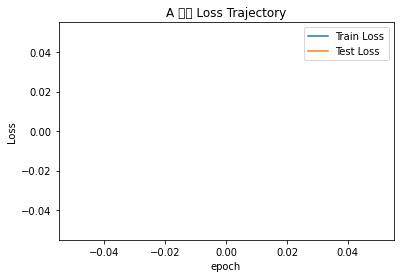

In [21]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('A 모델 Loss Trajectory')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
print()

In [22]:
# 예측 및 결과 확인: Deprecation Warning 주의
y_train_pred = model.predict(X_train_A)
y_test_pred = model.predict(X_test_A)
y_train_pred = np.reshape(np.where(y_train_pred > 0.5, 1, 0), y_train.shape)
y_test_pred = np.reshape(np.where(y_test_pred > 0.5, 1, 0), y_test.shape)
print(f"Train Accuracy: {accuracy_score(y_train_A, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test_A, y_test_pred)}")

AssertionError: ignored

## 2.4. [B] 임베딩 따로 한 모델 구성


### 1) IMDB -> 임베딩

In [ ]:
# 임베딩 레이어 구성
X_Input = Input(batch_shape=(None, max_length))
X_Embed = Embedding(input_dim=max_features, output_dim=n_embed, input_length=max_length)(X_Input)
X_Embed_2 = Dropout(0.2)(X_Embed) # 최종 임베딩

# 임베딩 모델 구조 확인
embedding_model = Model(X_Input, X_Embed_2)
print("========== 임베딩 모델 구조 확인 ==========")
print(embedding_model.summary())

### 2) 임베딩 -> CNN

In [ ]:
# CNN 네트워크 파라미터 설정
n_filters = int(input('컨볼루션 필터 개수 설정: '))
s_filters = int(input('컨볼루션 필터 사이즈 설정: '))

# CNN 네트워크 레이어 구성
X_Conv = Conv1D(filters=n_filters, kernel_size=s_filters, strides=1, padding='valid', activation='relu')(X_Embed_2)
X_Pool = GlobalMaxPooling1D()(X_Conv)
X_Dense = Dense(n_hidden, activation='relu')(X_Pool)
X_Dense_2 = Dropout(0.5)(X_Dense)
X_Flatten = Flatten()(X_Dense_2)

# CNN 네트워크 확인
cnn_model = Model(X_Input, X_Flatten)
print("========== CNN 모델 전체 구조 확인 ==========")
print(cnn_model.summary())

### 3) 임베딩 -> LSTM

In [ ]:
# LSTM 네트워크 레이어 구성
X_LSTM = Bidirectional(LSTM(n_hidden, activation='relu'))(X_Embed_2)

# LSTM 네트워크 확인
lstm_model = Model(X_Input_CNN, X_Flatten)
print("========== CNN 모델 전체 구조 확인 ==========")
print(cnn_model.summary())

### 4) 네트워크 연결

In [ ]:
# 두 층 concat
X_merge = Concatenate()([X_Flatten, X_LSTM])
y_output = Dense(1, activation='sigmoid')(X_merge)

model = Model([X_Input_CNN, X_Input_LSTM], y_output)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
print("========== 전체 모델 구조 확인 ==========")
print(model.summary())

### 5) 모델 학습

In [ ]:
# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
hist= model.fit([X_train, X_train], y_train,
                batch_size=BATCH,
                epochs=EPOCHS,
                validation_data=([X_test, X_test], y_test),
                callbacks=[es])

In [ ]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('B모델 Loss Trajectory')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
print()

In [ ]:
# 예측 및 결과 확인: Deprecation Warning 주의
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred = np.reshape(np.where(y_train_pred > 0.5, 1, 0), y_train.shape)
y_test_pred = np.reshape(np.where(y_test_pred > 0.5, 1, 0), y_test.shape)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")